# WANN experiments on Kin familly dataset

In [1]:
import copy
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.constraints import MinMaxNorm

sys.path.append("../wann")
from utils import kin, BaggingModels, cross_val
from kin_experiments import run_kin_experiments
from methods import *

from warnings import filterwarnings
filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load Dataset

In [2]:
source = 'kin-8nh'
target = 'kin-8fm'

N = 10   # Number of labeled target data
m = 200  # Number of labeled source data
n = 200  # Number of unlabeled target data

Xs, ys = kin(source)
Xt, yt = kin(target)
X = np.concatenate((Xs, Xt))
y = np.concatenate((ys, yt))

np.random.seed(0)
src_index = np.random.choice(len(Xs), m, replace=False)
tgt_index, tgt_test_index = train_test_split(range(len(Xs), len(Xs)+len(Xt)), train_size=n, test_size=2*n)
tgt_train_index = np.random.choice(tgt_index, N, replace=False)
train_index = np.concatenate((src_index, tgt_train_index))
shape = X.shape[1]

Kin data files successfully downloaded and saved in 'dataset/kin' folder


## Base Estimator

In [3]:
def get_base_model(shape, activation=None, C=1, name="BaseModel"):
    inputs = Input(shape=(shape,))
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(inputs)
    modeled = Dropout(0.5)(modeled)
    modeled = Dense(10, activation='relu',
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C))(modeled)
    modeled = Dropout(0.2)(modeled)
    modeled = Dense(1, activation=activation,
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C))(modeled)
    model = Model(inputs, modeled)
    model.compile(optimizer="adam", loss='mean_squared_error')
    return model

base_estimator = BaggingModels(func=get_base_model,
                               n_models=1,
                               n_jobs=None,
                               shape=shape,
                               C=1,
                               random_state=0)
fit_params = dict(epochs=300,
                  batch_size=32,
                  verbose=0)

## Examples

### No reweight

In [25]:
no_reweight = copy.deepcopy(base_estimator)
no_reweight.fit(X[train_index], y[train_index], **fit_params)

y_pred = no_reweight.predict(X)
score= mean_squared_error(y[tgt_test_index], y_pred[tgt_test_index])
print('Target score: %.4f'%score)

Target score: 0.0041


### Balanced Weighting

In [18]:
np.random.seed(0)
tf.random.set_seed(0)

balanced = BalancedWeighting(get_base_model)
balanced.fit(X, y, [src_index, tgt_train_index], **fit_params)

y_pred = balanced.predict(X)
score= mean_squared_error(y[tgt_test_index], y_pred[tgt_test_index])
print('Target score: %.4f'%score)

Target score: 0.0032


### TrAdaBoostR2

In [9]:
tradaboost = TwoStageTrAdaBoostR2(func=get_base_model,
                                  n_jobs=None,
                                  verbose=1,
                                  C=10,
                                  random_state=0,
                                  shape=X.shape[1])
tradaboost.fit(X, y, [src_index, tgt_train_index], **fit_params)
y_pred = tradaboost.predict(X)
score= mean_squared_error(y[tgt_test_index], y_pred[tgt_test_index])
print('Target score: %.4f'%score)

cv error of estimator 0: 0.006 (0.0053495852)
cv error of estimator 1: 0.006 (0.0051432123)
cv error of estimator 2: 0.005 (0.0034468802)
cv error of estimator 3: 0.009 (0.0071918475)
cv error of estimator 4: 0.017 (0.0136675252)
cv error of estimator 5: 0.023 (0.0165313069)
cv error of estimator 6: 0.034 (0.0246846864)
cv error of estimator 7: 0.040 (0.0293064804)
cv error of estimator 8: 0.047 (0.0291003117)
cv error of estimator 9: 0.051 (0.0263449143)
Target score: 0.0032


### KMM

In [5]:
kmm = KMM(base_estimator, sigma=0.1)
kmm.fit(X, y, index=[src_index, tgt_index, tgt_train_index], **fit_params)

y_pred = kmm.predict(X)
score= mean_squared_error(y[tgt_test_index], y_pred[tgt_test_index])
print('Target score: %.4f'%score)

Target score: 0.0183


### KLIEP

In [11]:
kliep = KLIEP(base_estimator)
kliep.fit(X, y, index=[train_index, tgt_index], **fit_params)

y_pred = kliep.predict(X)
score= mean_squared_error(y[tgt_test_index], y_pred[tgt_test_index])
print('Target score: %.4f'%score)

Target score: 0.0107


### WANN

In [12]:
np.random.seed(0)
tf.random.set_seed(0)

wann = WANN(get_base_model=get_base_model, C=1, C_w=1)
wann.fit(X, y, index=[src_index, tgt_train_index], epochs=300, batch_size=32, verbose=0)

y_pred = wann.predict(X)
score = mean_squared_error(y[tgt_test_index], y_pred[tgt_test_index])
print('Target score: %.4f'%score)

Target score: 0.0012


## Plot Weighting Maps

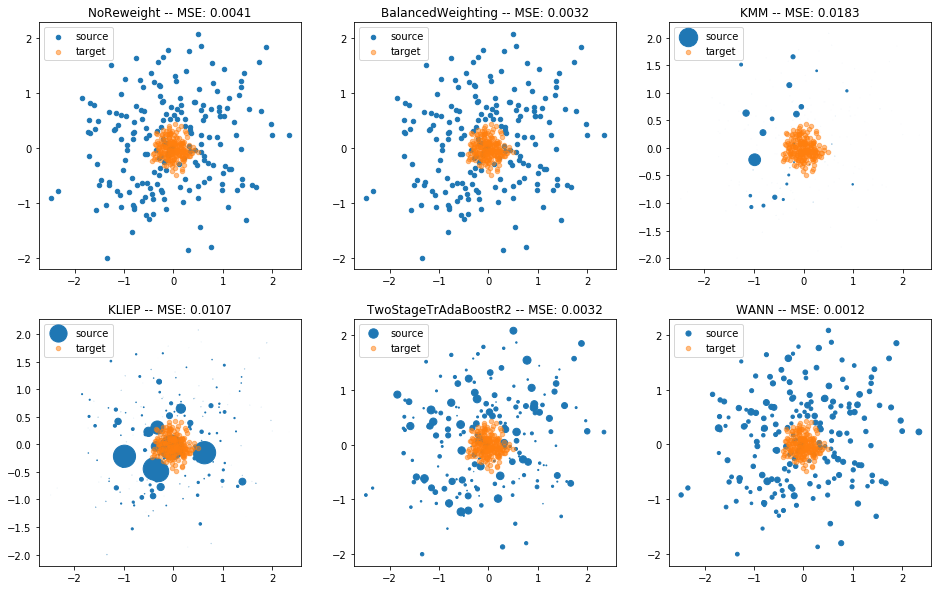

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

X_pca = PCA(2).fit_transform(X)

for method, ax in zip([no_reweight, balanced, kmm, kliep, tradaboost, wann], axes.ravel()):
    
    try:
        ws = method.get_weight(X[src_index]).ravel()
        ws /= ws.mean()
        ws *= 20
    except:
        try:
            ws = method.get_weight().ravel()
            ws /= ws.mean()
            ws *= 20
        except:
            ws=20
    
    title = method.__class__.__name__
    if method == no_reweight:
        title = "NoReweight"
        ws = 20
        
    if method == tradaboost:
        ws = tradaboost.sample_weights_[tradaboost.estimator_errors_.argmin()]
        ws /= ws.mean()
        ws *= 20
    
    y_pred = method.predict(X)
    score = mean_squared_error(y[tgt_test_index], y_pred[tgt_test_index])
    
    title += " -- MSE: %.4f"%score
    
    ax.scatter(X_pca[src_index, 0], X_pca[src_index, 1], s=ws, label="source")
    ax.scatter(X_pca[tgt_index, 0], X_pca[tgt_index, 1], s=20, alpha=0.5, label="target")
    ax.set_title(title)
    ax.legend()
    

## Run Experiments

In [42]:
df = run_kin_experiments(method="WANN",
                         get_base_model=get_base_model,
                         C=1,
                         C_w=1,
                         sigma=0.1,
                         epochs=300,
                         batch_size=32,
                         n_models=1,
                         n_jobs=None,
                         n_source=200,
                         n_target_unlabeled=200,
                         n_target_labeled=10,
                         n_target_test=400,
                         random_state=0,
                         save=False)

 
Experiment for method: WANN
 
############# kin-8fh #############
--------- kin-8fm ----------
Target_score: 0.0008
--------- kin-8nh ----------
Target_score: 0.0560
--------- kin-8nm ----------
Target_score: 0.0627
############# kin-8fm #############
--------- kin-8fh ----------
Target_score: 0.0019
--------- kin-8nh ----------
Target_score: 0.0531
--------- kin-8nm ----------
Target_score: 0.0601
############# kin-8nh #############
--------- kin-8fh ----------
Target_score: 0.0023
--------- kin-8fm ----------
Target_score: 0.0015
--------- kin-8nm ----------
Target_score: 0.0421
############# kin-8nm #############
--------- kin-8fh ----------
Target_score: 0.0025
--------- kin-8fm ----------
Target_score: 0.0008
--------- kin-8nh ----------
Target_score: 0.0347


### Launch all experiments (all methods, 10 times)
Uncomment cell below to launch experiments

In [12]:
# %run -i ..\wann\kin_experiments